# 카메라 스티커앱 만들기

## tensorflow GPU 확인

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

device_lib.list_local_devices()
print("\n")
tf.test.is_gpu_available('GPU')



Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-08-15 18:24:43.598120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


False

2022-08-15 18:24:45.320433: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-15 18:24:45.320477: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aiffel-GE75-Raider-10SF
2022-08-15 18:24:45.320487: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aiffel-GE75-Raider-10SF
2022-08-15 18:24:45.320621: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-08-15 18:24:45.320644: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.85.2
2022-08-15 18:24:45.320649: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.85.2


## 학습 목표

* 얼굴인식 카메라의 흐름 이해
* dlib 라이브러리 사용
* 이미지 배열의 인덱싱 예외 처리

## 이미지 준비

1. 얼굴 이미지를 넣는다.
2. 얼굴의 눈, 코, 입 등을 랜드마크(조정) 해서 얼굴의 위치를 잡는다.
3. 찾은 영역에 따라 머리 위에 왕관 스티커를 붙인다.

### 라이브러리 불러오기

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

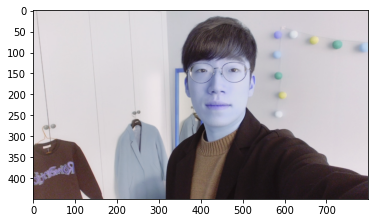

In [4]:
# my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
my_image_path = 'data/image.png'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

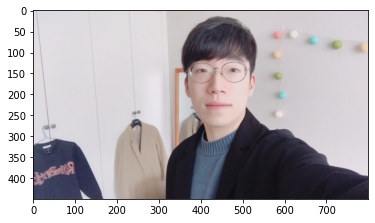

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 얼굴 검출 face detection

* dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾습니다.
* HOG : 이미지에서 색상의 변화량
* hog dector 선언
* hog로 이미지의 얼굴 bounding box 추출
* [get_frontal_face_detector](http://dlib.net/python/index.html#dlib_pybind11.get_frontal_face_detector)

* [image pyramid](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html) : 이미지를 upsampling을 통해 크기를 키우는 것
* 원본 이미지에서 다양한 얼굴을 찾기위해 동일 이미지를 다른 사이즈로 바뀐 set를 Image Pyramid라고 함
* 결국 원본 이미지의 서로 다른 크기의 이미지 세트

In [6]:
detector_hog = dlib.get_frontal_face_detector()
print(detector_hog)
print(type(detector_hog))

<class '_dlib_pybind11.fhog_object_detector'>


detector_hog 가 얼굴을 찾는 함수인겁니다.  
이미지 피라미드를 개수를 또 인자로 갖네요.  
여기서 이미지 피라미드는 upsampling 입니다.

In [7]:
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
# dlib_rects3 = detector_hog(img_rgb, 3)   # (image, num of image pyramid)

* [dlib_rects](http://dlib.net/python/index.html#dlib.rectangles)
* detector를 통해 나온 리턴 값은 사각형 개체의 array

In [8]:
print(dlib_rects)
# print(dlib_rects3)

# print(type(dlib_rects))

rectangles[[(345, 98) (531, 284)]]


plus count!


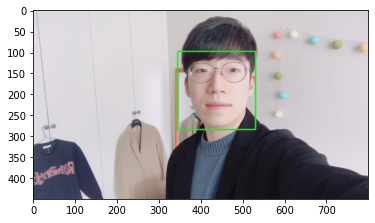

In [9]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    print("plus count!")

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

* class dlib.rectangle
  - This object represents a rectangular area of an image.
  - __init__(self: dlib.rectangle, left: int, top: int, right: int, bottom: int) -> None
* class dlib.rectangles
  - An array of rectangle objects.  
* rectangle 개체들의 array에서 각각의 rectangle의 좌우상하를 가정
* 현재 예제에서는 사각형 개체가 1개뿐(사람이 1명이기 때문)

## 얼굴 랜드마크 face landmark

* Object keypoint estimation  
  객체 내부에 점을 찾는 기술  
* Dlib landmark localization  
잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾습니다.

Dlib에서 제공하는 모델을 사용해보겠습니다.

In [10]:
# model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
model_path = 'data/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

* [shape_predictor](http://dlib.net/python/index.html#dlib_pybind11.shape_predictor)
* 주어진 model path에 따라 특정 shape를 predict 하는 함수 입니다.
* 얼굴 영역 박스 마다 face landmark를 찾아냅니다
* face landmark 좌표를 저장해둡니다

In [11]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

1. shape_predictor로 point란 것이 나옴
2. point의 parts() method를 통해 나온 위치 값들의 x,y 좌표를 알 수 있음.
3. parts()를 통해 (x 좌표, y 좌표)를 가지는 list를 만들어줌
4. 예시는 사각형이 1개지만 여러개가 될 수 있으므로 나온 list를 data로 가지는 list로 만들어 줌(리스트를 데이터로 가지는 리스트)

In [12]:
print(points.parts())

print("\n", list_points)
print(type(list_points))

print("\n", list_points[0])
print(type(list_points[0]))

print("\n", list_landmarks)
print(type(list_landmarks))

print("\n", list_landmarks[0])
print(type(list_landmarks[0]))

points[(368, 153), (368, 174), (371, 195), (376, 215), (382, 235), (391, 252), (404, 266), (420, 277), (441, 279), (461, 276), (480, 266), (495, 252), (508, 235), (516, 216), (520, 195), (523, 173), (524, 151), (377, 131), (386, 119), (399, 116), (413, 118), (425, 124), (454, 121), (466, 114), (481, 112), (494, 114), (503, 127), (439, 143), (438, 156), (438, 169), (437, 182), (423, 197), (431, 199), (438, 200), (446, 199), (454, 197), (391, 147), (399, 142), (409, 143), (416, 149), (408, 150), (399, 150), (464, 147), (472, 141), (482, 141), (489, 145), (482, 149), (473, 149), (411, 227), (421, 222), (432, 218), (439, 220), (446, 218), (458, 222), (471, 227), (458, 234), (446, 238), (438, 238), (431, 238), (420, 235), (415, 227), (432, 227), (439, 228), (447, 227), (466, 227), (446, 228), (438, 229), (431, 228)]

 [(368, 153), (368, 174), (371, 195), (376, 215), (382, 235), (391, 252), (404, 266), (420, 277), (441, 279), (461, 276), (480, 266), (495, 252), (508, 235), (516, 216), (520, 

1. list_landmarks 에 들어가 있는 landmark들 중에서 하나씩 봅니다. (예제는 1개니까 그냥 1번만 가겠죠)
2. 하나의 landmark 에서 point들을 가져와서
3. cv2.circle 를 통해 점을 그립니다.
4. cv2.circle(본판 이미지, 원을 그릴 위치(rec 또는 point 2개), 색(B,G,R), 굵기, 선종류)

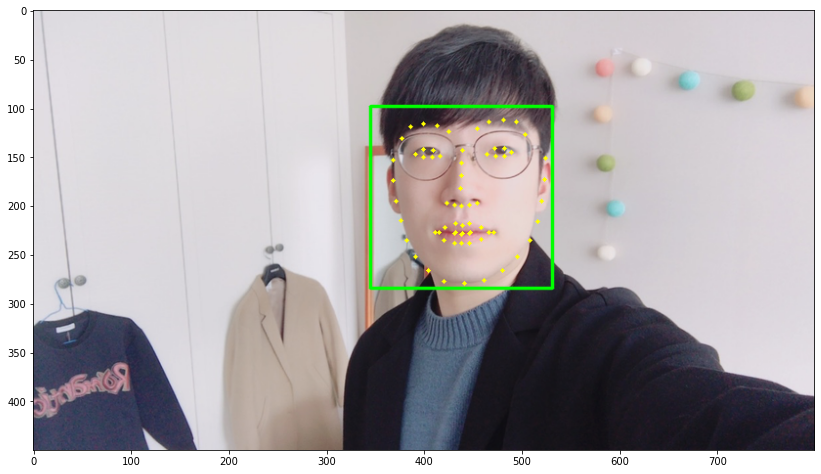

In [13]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (14,10))
plt.imshow(img_show_rgb)
plt.show()

## 스티커 적용하기

좌표 확인 : 코 위치가 idx 30 입니다.

In [14]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(437, 182)
(x,y) : (437,89)
(w,h) : (187,187)


* 랜드마크의 점들 중에서 30번째 점이 코의 위치입니다.
* 해당 위치의 x,y 좌표를 가져오지만
* 왕관의 중심하단 위치를 찾기위해 얼굴을 찾은 사각형의 높이의 반을 //을 통해 int값으로 구해서 y 좌표에서 위로 이동시킵니다.
* w,h = 사각형의 길이 (왕관 하단의 길이가 얼굴의 너비와 같아야 하기 때문에 그리고 높이는 왕관이 정사각형이라 보고 높이를 줍니다.)
* 코의 중심이 (437, 182)로 나옵니다.  
* 왕관을 불러와서 resize 해줍니다.
* 왕관을 출력해보니 비어있는 곳을 검은색으로 채워줍니다.

(187, 187, 3)


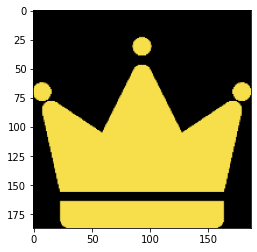

[]
[[  0   0   0]
 [  0   0   0]
 [ 77 223 248]
 [ 76 223 247]
 [ 76 223 247]
 [ 76 223 247]
 [ 76 223 247]
 [ 76 223 247]
 [ 76 223 247]
 [ 76 223 247]
 [ 76 223 247]
 [ 76 223 247]
 [ 76 223 247]
 [ 44 129 144]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0  

In [15]:
# sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
sticker_path = 'data/king.png'

img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

img_sticker_show = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_show)
plt.show()

print(img_sticker[img_sticker == 255])
print(img_sticker[64])

* 왕관을 넣을 좌표 위치를 조정합니다.  
* // 은 나눗셈으로 int를 return 합니다.
* 이미지를 넣기위해 왕관의 좌측 상단 위치를 구합니다.

In [16]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,-98)


왕관의 바탕 이미지의 크기를 벗어나서 -값이 나오는 것 입니다.  
위에만 튀어나오니 y값이 음수인 경우를 이미지를 없애줍니다.

In [17]:
# if refined_x < 0: 
#     img_sticker = img_sticker[:, -refined_x:]
#     refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,0)


In [18]:
print(img_sticker.shape)

(89, 187, 3)


* shape 는 너비, 높이, bgr
* 원본 이미지에 스티커를 적용합니다.  
* sticker_area는 원본 이미지(img_show)에 스티커를 적용할 위치를 :를 통해 crop한 이미지 입니다.
* 저희는 왕관이미지에서 검은색(0)을 제외한 이미지를 사용해서 붙입니다.
* 0인 부분은 원래 이미지 아닌 부분은 왕관을 넣습니다.
* np.where(조건문, 조건문 true일때 , 조건문 false 일때)를 사용합니다.
* np.where(스티커의 값이 0 일때 (T,F), 0일때는 기본화면(sticker_area), 0이 아닐때는 왕관) - broadcast를 통해 0인 값에서만 가져옵니다.(검은색에서)
* 그리고 rgb 중에 0이 부분일때만도 가져옵니다.
* 왕관의 비어있는 공간의 색 또한 opencv imread를 해주면 검은색(0,0,0)으로 만들어집니다.

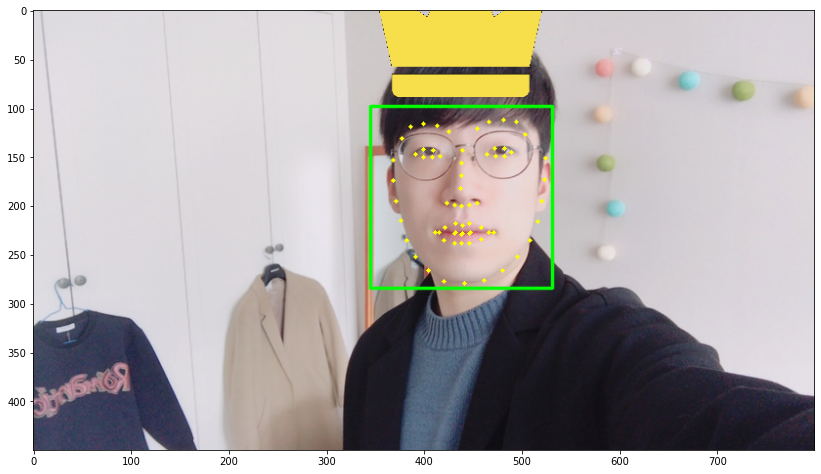

In [19]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.figure(figsize = (14,10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_bgr에 똑같이 적용하여 bounding box와 landmark를 제거하고 출력합니다.


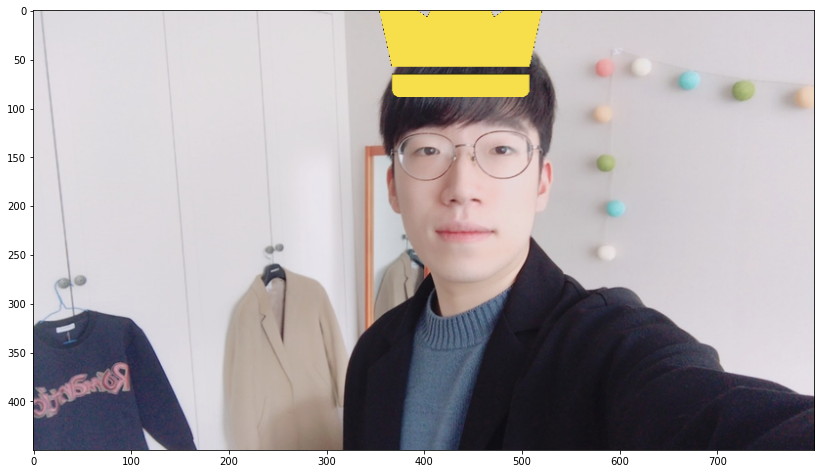

In [20]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.figure(figsize = (14,10))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()